# Determine Optimal Trajectories
The goal in this notebook is to identify trajecotires that produce better sampling of the space of potential training data. We first attempt to quantify the performance of a trajectory, then employ optimization algorithms to determine trajectories that opimitize this metric.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from stopping_power_ml.traj_design import TrajectoryOptimizer
from scipy import optimize
import pickle as pkl
import pandas as pd
import numpy as np
import itertools
import json
import gzip
import os

## Import the trajectories, sampling points, and sampling strategies
The bits of data useful for this analysis

In [2]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [3]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

Load the points created by randomly sampling space

In [4]:
sampling_data = pd.read_pickle('sampled_space.pkl.gz')

Load in the projection learned from the sampling space

In [5]:
with gzip.open('manifold.pkl.gz', 'rb') as fp:
    manifold = pkl.load(fp)

Load the feature generator

In [6]:
with open(os.path.join('..', '..', 'featurizers.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

Load the list of features used to determine the mainfold

In [7]:
with open('manifold_features.pkl', 'rb') as fp:
    X_cols = pkl.load(fp)

Load in the simulation cell

In [8]:
with open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb') as fp:
    simulation_cell = pkl.load(fp)

## Create tool for quantifying degree of sampling
We use an approach of finding what fraction of points in the sampling space we pass "near." 

Project the sampling data. We'll use this often in plots

In [9]:
sampling_proj = manifold.transform(sampling_data[X_cols])

Use 5% of the total variation in the manifold as a metric for distance

In [10]:
thr_dist = (sampling_proj.max() - sampling_proj.min()) * 0.05
print('Threshold distance: {:.2f}'.format(thr_dist))

Threshold distance: 1.33


Make the TrajectoryOptimizer - a tool we use frequently in this notebook

In [11]:
%%time
trajopt = TrajectoryOptimizer(sampling_data, manifold, X_cols, thr_dist, featurizers)

CPU times: user 17.2 s, sys: 6.12 s, total: 23.4 s
Wall time: 8.88 s


Plot the random trajectory, to visualize our matching procedure

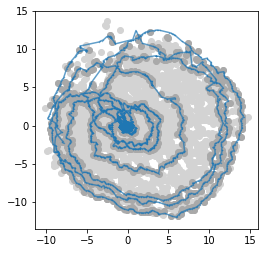

In [12]:
fig, ax = plt.subplots()

# Get the points the random trajectory passes near
hits = trajopt.get_near_points(random_data)

# Get the projection of the random trajectory
random_proj = manifold.transform(random_data[X_cols])

ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7)

fig.set_size_inches(4, 4)

Measure the performance of the two trajectories

In [13]:
random_score = trajopt.score_sampling_performance(random_data)
print('Random trajectory score: {:.1f}%'.format(random_score * 100))

Random trajectory score: 21.7%


In [14]:
channel_score = trajopt.score_sampling_performance(channel_data)
print('Channel trajectory score: {:.2f}%'.format(channel_score * 100))

Channel trajectory score: 0.48%


In [15]:
assert random_score > channel_score

*Finding*: Yes, the random trajecotry seems to perform better. It samples >10x more of the space

## Can I find a better trajectory?
Only 20% of the search space is not particularly impressive. 

First, get the size of the random trajectory

In [16]:
traj_len = random_data['displacement'].max()
traj_time = len(random_data)
print('The trajectory is {:.1f} a_B and {} timesteps long'.format(
    traj_len, traj_time
))

The trajectory is 140.0 a_B and 9800 timesteps long


Get the azimuth and inclination of the random trajectory

In [17]:
start = random_data.iloc[0]

In [18]:
theta = np.arccos(start['velocity'][2] / np.linalg.norm(start['velocity']))
phi = np.arctan2(start['velocity'][1], start['velocity'][0])

Verify the trajecotry optimizer yields a result close to the ranodm trajecotry

In [19]:
%%time
score = trajopt.score_trajectory(start['position'], (theta, phi), 1, traj_len, traj_time)
print('Example score: {:.2f}%'.format(score * 100))
assert np.isclose(score, random_score, atol=0.02).all()

Example score: 21.71%
CPU times: user 15.4 s, sys: 8.61 s, total: 24 s
Wall time: 18.7 s


Optimize the trajectory. Here, I'm using basinhopping naively

In [20]:
x0 = np.hstack((start['position'], (theta, phi)))
print('Initial:', x0)

Initial: [0.         5.74196597 5.74196597 0.76317229 1.22792537]


In [21]:
%%time
opt_result = optimize.basinhopping(lambda x: -trajopt.score_trajectory(x[:3], x[3:], 1, traj_len, traj_time),
                                   x0, niter=100, stepsize=2)

CPU times: user 13h 46min 57s, sys: 6h 41min 23s, total: 20h 28min 20s
Wall time: 16h 33min 38s


In [22]:
opt_result

                        fun: -0.243896484375
 lowest_optimization_result:       fun: -0.243896484375
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-2.24402591, 10.29656781,  5.62153947,  5.11866557,  4.29652645])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 3
                       nfev: 3235
                        nit: 100
                       njev: 457
                          x: array([-2.24402591, 10.29656781,  5.62153947,  5.11866557,  4.29652645])

In [23]:
opt_traj = opt_result.x
print('Optimized:', opt_traj)

Optimized: [-2.24402591 10.29656781  5.62153947  5.11866557  4.29652645]


In [24]:
opt_start, opt_direction = opt_traj[:3], opt_traj[3:]

In [25]:
opt_vel = np.array([np.sin(opt_direction[0]) * np.cos(opt_direction[1]), 
                    np.sin(opt_direction[0]) * np.sin(opt_direction[1]),
                    np.cos(opt_direction[0])])

In [26]:
print('Optimized starting:', opt_start)
print('Optimized velcoity:', opt_vel)

Optimized starting: [-2.24402591 10.29656781  5.62153947]
Optimized velcoity: [0.37109465 0.84030485 0.39519175]


In [27]:
score = trajopt.score_trajectory(opt_start, opt_direction, 1, traj_len, traj_time)
print('Optimized score: {:.2f}%'.format(score * 100))

Optimized score: 24.39%


Plot the trajectory over time, to see if the optimization is better

In [28]:
steps = np.linspace(0, 1, 40+1)

In [29]:
%%time
random_over_time = [0] + [trajopt.score_trajectory(start['position'], (theta, phi), 1,
                                                   traj_len=traj_len*x, 
                                                   nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 8min 17s, sys: 2min 53s, total: 11min 10s
Wall time: 7min 9s


In [30]:
%%time
opt_over_time = [0] + [trajopt.score_trajectory(opt_start, opt_direction, 1,
                                                traj_len=traj_len*x,
                                                nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 8min 12s, sys: 2min 50s, total: 11min 3s
Wall time: 7min 13s


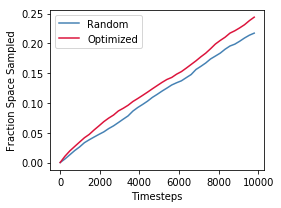

In [31]:
fig, ax = plt.subplots()

ax.plot(steps * traj_time, random_over_time, color='steelblue', label='Random')
ax.plot(steps * traj_time, opt_over_time, color='crimson', label='Optimized')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Fraction Space Sampled')

ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-comparison.png'), dpi=320)

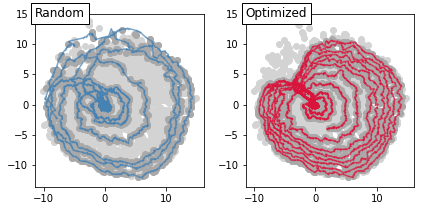

In [32]:
fig, axs = plt.subplots(1, 2)

# Generate the optimized trajectory
opt_data = trajopt.generate_trajectory(opt_start, opt_direction, 1,
                                      traj_len, traj_time)

for ax, traj, c, l in zip(axs, [random_data, opt_data],
                      ['steelblue', 'crimson'],
                      ['Random', 'Optimized']):
    # Get the points the random trajectory and passes near
    hits = trajopt.get_near_points(traj)

    # Get the projection of the random trajectory
    random_proj = manifold.transform(traj[X_cols])

    # Plot the trajectory
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
    ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

    ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7,
           color=c)
    
    # Label it
    ax.text(0, 1, l, va='center', transform=ax.transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
fig.set_size_inches(6, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'traj_comparison.png'), dpi=320)

*Finding*: The optimized trajecotry samples space much more efficiently than the random. 

## Optimize Several Trajectories Concurrently
It might be better to sample space with two different trajectories. Let's see if we can get better sampling with the same number of steps

In [33]:
# Make sure sampling the same trajectory twice yields the same results
assert np.isclose(trajopt.score_multiple_trajectories([opt_traj], 1, traj_len/2, traj_time/2), 
                  trajopt.score_multiple_trajectories([opt_traj, opt_traj], 1, traj_len, traj_time)).all()

Optimize two trajectories. Use the optimized single trajectory split into two parts as a starting point

In [34]:
multiopt_start = opt_start + opt_vel * traj_len / 2

In [35]:
x0 = np.hstack((opt_start, opt_direction, multiopt_start, opt_direction))
print('Initial:', x0.reshape(-1, 5))
score = trajopt.score_multiple_trajectories(x0.reshape(-1, 5), 1, traj_len, traj_time)
print('Optimized score: {:.2f}%'.format(score * 100))

Initial: [[-2.24402591 10.29656781  5.62153947  5.11866557  4.29652645]
 [23.72683528 69.10485452 33.27882356  5.11866557  4.29652645]]
Optimized score: 24.08%


Run the optimization algorithm

In [36]:
%%time
opt_result = optimize.basinhopping(lambda x: -trajopt.score_multiple_trajectories(np.reshape(x, (-1, 5)), 1, traj_len, traj_time), x0, 
                                   niter=100, stepsize=2)

CPU times: user 21h 33min 44s, sys: 6h 35min 42s, total: 1d 4h 9min 26s
Wall time: 3d 6h 11min 3s


In [37]:
opt_result

                        fun: -0.24078369140625
 lowest_optimization_result:       fun: -0.24078369140625
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-2.24402591, 10.29656781,  5.62153947,  5.11866557,  4.29652645,
       23.72683528, 69.10485452, 33.27882356,  5.11866557,  4.29652645])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev

In [38]:
opt_trajs = opt_result.x.reshape((-1, 5))
print('Optimized:', opt_trajs)

Optimized: [[-2.24402591 10.29656781  5.62153947  5.11866557  4.29652645]
 [23.72683528 69.10485452 33.27882356  5.11866557  4.29652645]]


In [39]:
score = trajopt.score_multiple_trajectories(opt_trajs, 1, traj_len, traj_time)
print('Optimized score: {:.2f}%'.format(score * 100))

Optimized score: 24.08%


Compare the sampling performance

In [40]:
%%time
opt2_over_time = [0] + [trajopt.score_multiple_trajectories(opt_trajs, 1, 
                                                            traj_len=traj_len*x,
                                                            nsteps=int(traj_time * x)) 
                           for x in steps[1:]]

CPU times: user 13min 12s, sys: 3min 56s, total: 17min 9s
Wall time: 9min 24s


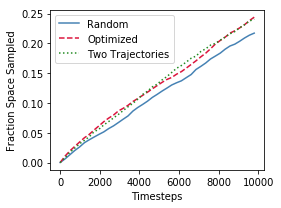

In [41]:
fig, ax = plt.subplots()

ax.plot(steps * traj_time, random_over_time, '-', color='steelblue', label='Random')
ax.plot(steps * traj_time, opt_over_time, '--', color='crimson', label='Optimized')
ax.plot(steps * traj_time, opt2_over_time, ':', color='forestgreen', label='Two Trajectories')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Fraction Space Sampled')

ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-comparison.png'), dpi=320)

Plot the trajectories

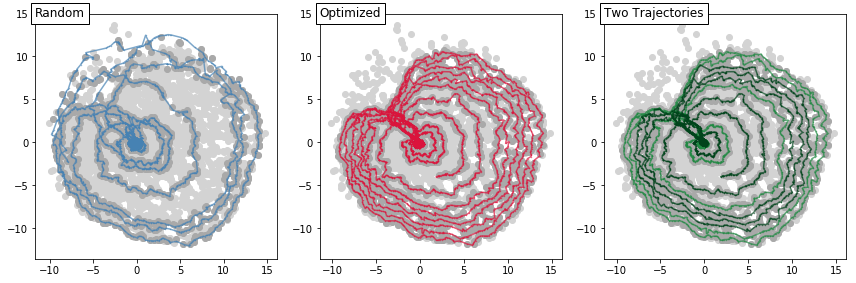

In [42]:
fig, axs = plt.subplots(1, 3)

# Plot the single trajecotires
for ax, traj, c, l in zip(axs, [random_data, opt_data],
                      ['steelblue', 'crimson'],
                      ['Random', 'Optimized']):
    # Get the points the random trajectory and passes near
    hits = trajopt.get_near_points(traj)

    # Get the projection of the random trajectory
    random_proj = manifold.transform(traj[X_cols])

    # Plot the trajectory
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
    ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

    ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7,
           color=c)
    
    # Label it
    ax.text(0, 1, l, va='center', transform=ax.transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
# Plot the double trajecotry
cmap = cm.get_cmap('Greens')

# Determine the length of each trajectory
sub_nsteps = int(traj_time / len(opt_trajs))
sub_len = traj_len / len(opt_trajs)

# Initialize the trajectory plot
axs[2].scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')

# Get the points sampled by each trajectory
points = set()
trajs_proj = []
for i,traj in enumerate(opt_trajs):
    # Project the trajectory
    opt2_traj = trajopt.generate_trajectory(traj[:3], traj[3:], 1, sub_len, sub_nsteps)
    hits = trajopt.get_near_points(opt2_traj)
    
    # Project the trajectory
    trajs_proj.append(manifold.transform(opt2_traj[X_cols]))
    
    axs[2].scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

# Plot the trajectories (later, so no points are on top)
for i,traj in enumerate(trajs_proj):
    axs[2].plot(traj[:, 0], traj[:, 1], '.-', ms=0.8, alpha=0.7,
               color=cmap((i + 3) / (len(opt_trajs) + 2)))
    
# Label it
axs[2].text(0, 1, 'Two Trajectories', va='center', transform=axs[2].transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
    
fig.set_size_inches(12, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'traj_comparison_with_double.png'), dpi=320)

*Finding*: The double trajectory does not add much. This is not surprising given that the rate of sampling new environments is roughly constant for the single trajectory

## Save Results
Save results that could be useful later

Save the trajectories

In [43]:
with open('optimized_trajecotries.json', 'w') as fp:
    json.dump({
        'double': opt_trajs.tolist(),
        'single': opt_traj.tolist()
    }, fp)

Save the trajectory sampling rates

In [44]:
with open('sampling-rates.json', 'w') as fp:
    json.dump({
        'random': random_over_time,
        'steps': (steps * traj_time).tolist(),
        'single': opt_over_time,
        'double': opt2_over_time,
    }, fp)

Save the trajectory optimizer

In [45]:
with gzip.open('traj_optimizer.pkl.gz', 'wb', 9) as fp:
    pkl.dump(trajopt, fp)

*Ideas*: Apply a penalty for trajectories that pass too close to atoms